# Machine Learning and Statistics Project 2020
by Angela Carpenter


# Table of Contents
- Project Instructions / Overview
- Python Libraries
- Loading / Reading in the dataset
- Exploratory Data Analysis
- Cleaning the Datasets
- Regression Models
- Neural Networks
- Predicting on new data / saving models for web app.
- Summary and Conclusions
- References


## Project Instructions

The aim of this project is to create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. A web service must also be developed that will respond with predicted power values based on speed values sent as HTTP requests. 




### notes to self - scratch all this later


- Tidy up the notebook, exclude a lot of the theory which is for my own knowledge

- Just make some notes on why I didn't scale or normalise the data
- Finish the web app side

- Need to tidy up the section on a brief background of wind turbines, just to see how it relates to the s-curve and not going into the physics of how wind turbines actually work. 

- Need to decide on final parameters for the keras neural network and save a model to use with a flask app.
- Load all the libraries at the top
- Fix all the references and use numbering
- For now I'll put some notes in the readme but will delete later

#### Read in the dataset

### Libraries used
The following python libraries are used in this notebook:


- import numpy as np
- import pandas as pd  
- import matplotlib.pyplot as plt 
- import seaborn as sns
- import pickle
- from joblib import dump, load
- from sklearn.preprocessing import PolynomialFeatures
- from sklearn.model_selection import train_test_split
- from sklearn.linear_model import LinearRegression
- from sklearn import linear_model
- from sklearn.pipeline import Pipeline
- from sklearn.metrics import mean_squared_error, r2_score

- import tensorflow.keras as kr
- print(kr.__version__)

#### pickle and joblib
The models must be saved for later use in the web service application.
For the polynomial regression model, there is the option of  using Python’s built-in persistence model `pickle`. The [scikit-learn documents](
https://scikit-learn.org/stable/modules/model_persistence.html) recommend using joblib’s replacement of pickle (dump & load), which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators, but can only pickle to the disk and not to a string.




In [1]:
# first importing the following libraries
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns

#import csv
# save a model in scikit-learn by using Python’s built-in persistence model pickle:
import pickle
# In the specific case of scikit-learn, it may be better to use joblib’s replacement of pickle
from joblib import dump, load

In [2]:
# save link to data and reference the link 
csv_url = 'https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv'
# read the csv data into a pandas dataframe
df = pd.read_csv(csv_url)
df
# write the dataframe to csv
df.to_csv('df.csv')
# make a copy of the dataframe
dfx = df.copy()

The power variable represents wind turbine power output and the speed values are wind speed values.
I don't think there is a need for this as such

### Zero and Null values

There are no null values in the dataset but there are some zero values. Null values are not zero in Python.
While there is only one zero value for the `speed` variable, there are 49 zero values for the `power` variable.

(Will look at the distribution of values to see if the zero values are very unusual compared to the remaining 451 values for the power variable.)

In [4]:
print(df.isnull().sum())
df.notnull().sum()
df.isnull().values.any()

speed    0
power    0
dtype: int64


False

In [5]:
# https://stackoverflow.com/questions/50767452/check-if-dataframe-has-a-zero-element
0 in df.values
df.isin([0]).any().any()

True

In [6]:
#https://stackoverflow.com/questions/29229600/counting-number-of-zeros-per-row-by-pandas-dataframe

df.isin([0]).sum()

speed     1
power    49
dtype: int64

In [7]:
df.sort_values(by='speed').head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [8]:
df.sort_values(by='speed', ascending=False).head()

,speed,power
499,25.000,0.0
498,24.950,0.0
497,24.875,0.0
496,24.850,0.0
495,24.775,0.0


In [9]:
df.sort_values(by='power', ascending=False).head()

,speed,power
461,23.273,113.556
416,20.646,112.362
447,22.497,109.932
420,20.871,108.485
464,23.348,108.167


In [10]:
df.sort_values(by='power').head()

,speed,power
0,0.000,0.0
111,5.806,0.0
110,5.781,0.0
105,5.556,0.0
89,4.880,0.0


In [11]:
df.sort_values(by='speed').head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


## Exploratory Data Analysis

Exploratory data analysis generally involves both non-graphical methods which include calculation of summary statistics and graphical methods which summarises the data in a picture or a plot. These methods can be univariate where one variable is looked at at a time or multivariate where two or more variables are looked at together to explore relationships. First I will do so some univariate EDA on both of the components before going on to do multivariate EDA. 
Plots can highlight any obvious relationships between the different variables in the dataset. They can also be used to identify any groups of observations that are clearly separate to other groups of observations.

### The distribution of speed and power values
Histograms are used to show the distribution of a single quantitative variable such as speed or power values, including the centre and spread of the distribution and if there is any skew in the data. 

The histogram of wind speed looks to be uniformly distributed with wind speed values spread out from zero up to 25 which seems to be the max speed value. Power values on the other hand looks to be bimodal with two defined peaks, one around zero power values and the second around the 100 kilowatt mark. 

The wind turbine power values seem to have a peak at very low values. This is not surprising given the large number of zero power values in this dataset. Almost 10% of the power values supplied are zero.  There is another peak around values of 95-100. Most of the remaining power values fall between 18 and 85.
A scatter plot can be used to see if there is any visible relationship between the two variables. 

The scatter plot shows a non-linear relationship between wind speed values and power. There does appear to be a linear relationship for mid-range speed values only.
- When wind speed increases from very low levels, the power does not increase by much or at all. 
- The wind turbine power values does start to increase with the wind speed from wind speed values of about 5 to about 18/19. 
- From wind speeds of 20 onwards to about 25 the power values increase no further and seem to level off. 

From looking at the curves and knowing very little about wind, you would guess that at very low winds there may not be enough speed to get the turbine up and running and generating power and that there might be a maximum power that can be achieved by the wind turbine regardless of how high the wind can go. Once the turbine is in motion, little is required to keep it going. Some of the power generated might be consumed by the turbine itself at low levels to get it started.

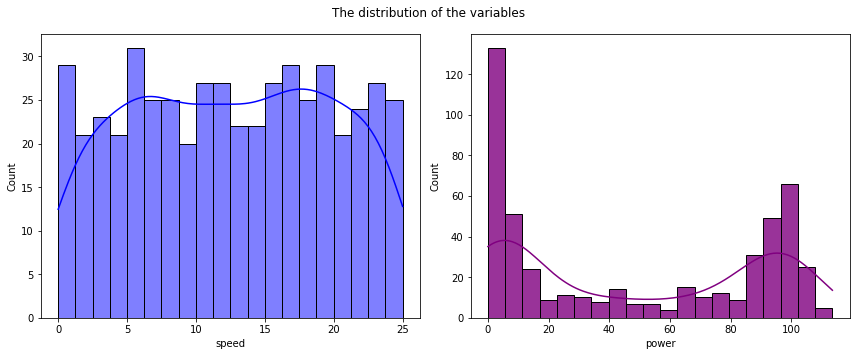

In [12]:
    %matplotlib inline

    # plot the histograms of Speed values
    f, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(data=df, x="speed", ax=axs[0], bins=20, kde=True,color="blue")
    sns.histplot(data=df, x="power", alpha=.8, legend=False, ax=axs[1], bins=20, kde=True, color="purple")

    #plt.title("Speed vs Power");
    plt.suptitle("The distribution of the variables")
    f.tight_layout()

### Summary statistics of the dataset
When looking at quantitative variables such as wind speed and power values, the characteristics of interest are the centre, spread, modality (the number of peaks in the pdf), the shape of the distribution and the outliers.
Panda's `describe` function generates statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution. (excluding NaN values)
The central tendency or location of the data distribution is determined by the typical or middle values. While the mean value is the average value in the dataset it may not be typical of the values in the dataset if there are very small or very large values in the dataset. The median is another measure of central tendancy - it is the middle value after all the values are put in an ordered list.
The mean and median are similar for symmetric distributions whereas for unimodal skewed distributions the mean will be more in the direction of the long tail of the distribution. 
The median can be considered a more typical value in the dataset or closer to some of the typical values and is also considered [robust](https://en.wikipedia.org/wiki/Robust_statistics) which means that removing some of the data will not tend to change the value of the median. A few extreme values will not affect the median as they would affect the mean. 
In this dataset the mean and median wind speed values are similar at approx 12.5 to 12.6.
The median power value is just over 41 compared to the mean power value of 48.
As we saw above, there are many zero values for power in the dataset. At least 10% of the power values are zero and probably for valid reasons.

In [13]:
# get summary statistics of the numerical values, 
df.describe() # get statistics summary of the

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


In [14]:
print("The mean speed value is %.3f" %df['speed'].mean(),"while the median speed value  is %.3f" %df['speed'].quantile(q=0.5))
print("The mean power value is %.3f" %df['power'].mean(),"while the median power value  is %.3f" %df['power'].quantile(q=0.5))

The mean speed value is 12.590 while the median speed value  is 12.550
The mean power value is 48.015 while the median power value  is 41.645


#### Spread statistics
The variance and standard deviation statistics can be used to show the spread of the distribution of the speed and power data values and how far away from the centre the data points are located.
The variance is the average of the squared deviations of each observation from the centre or mean of the data while the standard deviation is the square root of the variance and is in the same units as the data and therefore can be more easily interpreted. 
The range of values in the data is shown by the minimum and maximum values and is not considered a robust measure of spread but it is useful for showing possible errors or outliers. 

In [15]:
#print(f"The variance and standard deviations of speed values  are {df['speed'].var():.3f} and {df['speed'].std():.3f}")
#print(f"The variance and standard deviations of power values are {df['power'].var():.3f} and {df['power'].std():.3f}")
print(f"The standard deviations of speed values  is {df['speed'].std():.3f}")
print(f"The standard deviations of power values is {df['power'].std():.3f}")
print(f"The minimum speed value is {df['speed'].min()} while the maximum speed value is { df['speed'].max()} giving range of {df['speed'].max() - df['speed'].min()}")
print(f"The minimum Power value is {df['power'].min()} while the maximum power value is { df['power'].max()} giving range of {df['power'].max() - df['power'].min()}")

The standard deviations of speed values  is 7.225
The standard deviations of power values is 41.615
The minimum speed value is 0.0 while the maximum speed value is 25.0 giving range of 25.0
The minimum Power value is 0.0 while the maximum power value is 113.556 giving range of 113.556


The percentiles or quartiles of the speed and power values can be used to see the spread of the data values. The Interquartile range (IQR) is calculated by taking the 75% percentile or 3rd quartile minus the 25% percentile or first quartile and captures half of the values, the middle values of the data. Data that is more spread out will have a higher IQR. The IQR is considered a more robust measure of spread than the variance and standard deviation and will be more clearly shown in the boxplots further down. The IQR does not consider the data below the 25% percentile or above the 75% percentile which may contain outliers. The statistics here show that the *power* variable in this dataset is much more spread out or variable than the *speed* variable.  

In [16]:
print(f"The median speed value is {df['speed'].quantile(q=0.5)} with the IQR ranging from {df['speed'].quantile(q=0.25):.2f} to  {df['speed'].quantile(q=0.75):.2f}")
print(f"The median power value is {df['power'].quantile(q=0.5)} with the IQR ranging from {df['power'].quantile(q=0.25):.2f} to  {df['power'].quantile(q=0.75):.2f}")

The median speed value is 12.5505 with the IQR ranging from 6.32 to  18.78
The median power value is 41.6455 with the IQR ranging from 5.29 to  93.54


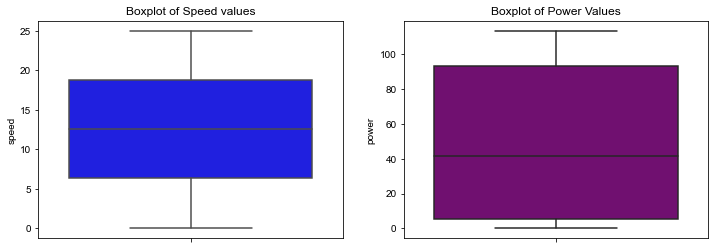

In [17]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.set(style="ticks", palette="pastel")
sns.boxplot(y=df['speed'], ax=axes[0], color="blue")
# add a title
axes[0].set_title("Boxplot of Speed values")
sns.boxplot(y=df['power'], ax=axes[1], color="purple")
axes[1].set_title("Boxplot of Power Values");

## Investigating a relationship between Wind Speed and Wind Turbine Power output

The skewness of the data is a measure of assymetry which can be seen by the lopsidedness of a boxplot.
Wind speed appears to be quite symmetric. The wind speed boxplot is cut pretty much in half by the median. Power appears to be soemwhat skewed to the right as the boxplot shows more of the box to the right or above the median line.
A boxplot with the median closer to the lower quartile is considered positively skewed. Positively skewed data has the mean greater than the median and it can be interpreted as having a higher frequency of high valued scores. The lower values of power are closer together than the higher power values.


Scatter plots are useful to identify trends and patterns in a dataset which might indicate a relationship between variables. The dataset here contains two numerical variables wind speed and turbine power values. 
The ordered pairs of numbers consisting of the independent variable wind 'speed' and the dependent variable 'power' output are plotted below resulting in a joint distribution of the two variables. Each point represents an actual observation is the dataset with a speed and a corresponding power value. 
The scatter plot shows an increasing linear trend in the middle range of the wind speed values. This would indicate that for increasing wind speeds in this range, power output values do increase, but only after a minimum wind speed has been reached. Power outputs then increase in line with increases in wind speed until it reaches a peak and plateaus.

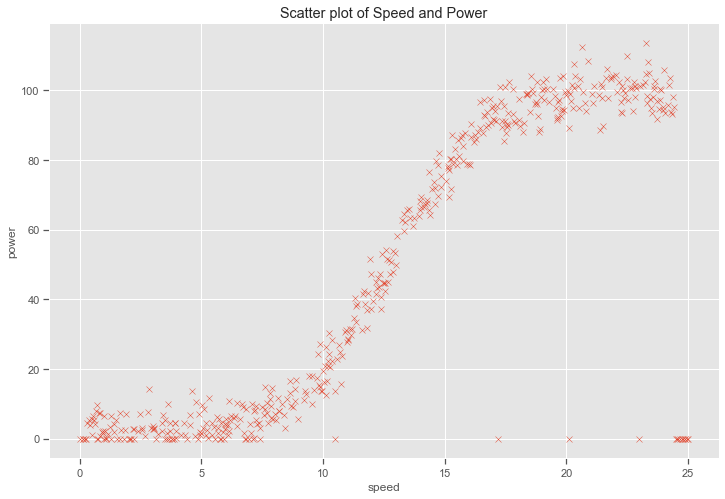

In [18]:
# create the plot



plt.style.use('ggplot')

# Plot size.
plt.rcParams['figure.figsize'] = (12, 8)
sns.scatterplot(x=df['speed'],y=df['power'], marker="x")
plt.grid(True)
# add title
plt.title("Scatter plot of Speed and Power");

#### Correlation and Covariance of Speed and Power values
 
For two quantitative variables such as the wind speed and power values, the covariance and correlation can also be used to determine whether a linear relationship between variables does exist and to show if one variable tends to occur with large or small values of another variable. The correlation statistics puts a numerical value on the strength and direction of the relationship.  The correlation coefficient here of 0.85 shows there is a very strong positive relationship between the wind speed and turbine power output.  The scatter plot shows a non-linear relationship between the variables. There appears to be a curved pattern in the data so the statistic cannot be taken on it's own.


In [19]:
df.corr()

,speed,power
speed,1.000000,0.853778
power,0.853778,1.000000


### Regression plots
The Python Seaborn library has some regression plots that can be used to quickly visualise relationships and patterns that may exist in the data. They use statistical models to estimate a simple relationship between sets of observations and are mainly used to visualise patterns in a dataset during the exploratory data analysis.
The scatter plot earlier showed a relationship between wind speeds and wind turbine power that is non-linear. There does seem to be a somewhat linear relationship for wind speeds between values of about 10 up to about 18 or so. Therefore it is worth looking at higher order polynomials as well as linear regression.
The plot below shows that the polynomial with order 3 looks a much better fit to the line than the first or second order linear regression lines. It is important not to go down the road of overfitting the data though.

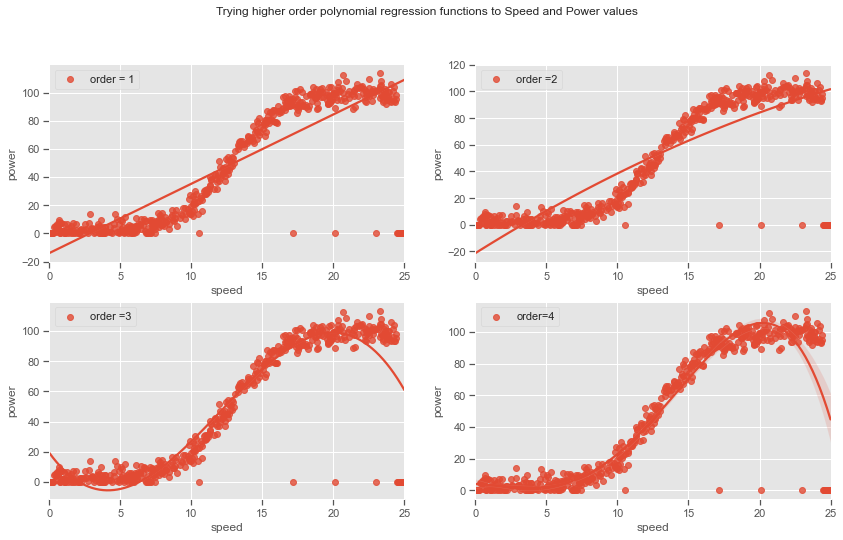

In [20]:
f, axes = plt.subplots(2, 2, figsize=(14, 8))
x = "speed"
y = "power"
sns.regplot(x="speed", y="power", data=df, ax=axes[0,0], label="order = 1", ci=False); axes[0,0].legend()
sns.regplot(x="speed", y="power", data=df, order=2, ax=axes[0,1], label="order =2", ci=False); axes[0,1].legend()
sns.regplot(x="speed", y="power", data=df, order=3, ax=axes[1,0], label="order =3", ci=False); axes[1,0].legend()
sns.regplot(x="speed", y="power", data=df, order=4, ax=axes[1,1], label = "order=4"); axes[1,1].legend()
plt.legend()
plt.suptitle("Trying higher order polynomial regression functions to Speed and Power values")
plt.show()

Residual plots can be used to check whether the simple regression model of speed ~ power  is appropriate for a dataset. The seaborn `residplot` fits and removes a simple linear regression and then plots the residual values for each observation. Ideally, these values should be randomly scattered around y = 0. If there is structure in the residuals, this suggests that simple linear regression is not appropriate for the data. The residual plot here has a shape which suggest non-linearity in the data set as expected.

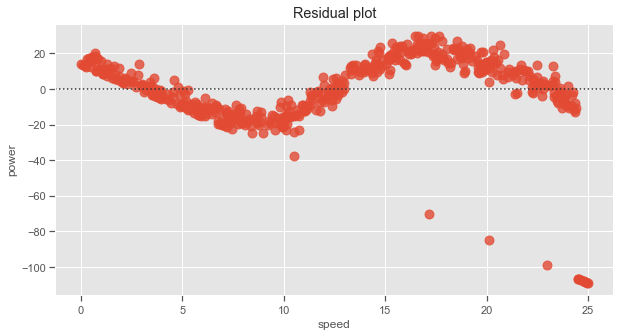

In [21]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.residplot(x="speed", y="power", data=df, scatter_kws={"s": 80})
plt.title("Residual plot"); plt.show()

---
## Researching Wind Turbines
### Drop most of this, just to explain the S-curve and the reasons for the zero values.

The dataset consists of two columns each containing 500 floating numbers under the column names `speed` and `power`. There are no other features provided.  I'm not getting into too much specifics about wind turbines but some background would help in understanding the dataset and the relationship between wind speed and power output.
The background to the project is related to wind farms supplying electricity to the supply grid and negotiating prices in advance.  In the electricity market, producers of electricity usually sell their electricity ahead of time and enter into a contract where they agree to produce a certain number of kilowatts of electricity during at a certain time, maybe between 11am one day and the next. The price is negotiated in advance of generating electricity and pushing it onto the supply grid. 
It is easier for those burning coal or gas or doing nuclear fusion to burn the right amount to generate the right amount of electricity. However with wind turbines you cannot tell how much electricity you will generate tomorrow because your generation of electricity depends on wind power. Therefore you can make an estimate by getting some meterological data from a weather prediction agent such as Met Eireann and use the weather prediction to help you predict how much electricity you are likely to produce. The prediction may not always be correct but you aim to reduce how often your calculations are wrong. The aim is to be able to predict that when wind speed is X amount that the power produced from the turbines is Y amount. 

A little research here suggests that the wind speed values are measured in metres per second and that the power values are measured in kilowatts.

[The Irish Wind Energy Association (IWEA)](https://www.iwea.com/about-us/about-us) is the representative body for the Irish wind industry, working to promote wind energy as an essential, economical and environmentally friendly part of the country’s low-carbon energy future. They note here that in 2018 wind energy provided 29 per cent of Ireland’s electricity. Each quarter, both EirGrid and ESBN publish updated wind farm statistics for Ireland at [ESBN Connected Wind Farms](https://www.esbnetworks.ie/new-connections/generator-connections/generator-connection-statistics). There is currently 4,130 MW of installed capacity in ROI and new Eirgrid link here http://www.eirgridgroup.com/how-the-grid-works/renewables/

Also on this website is a question about how much electricity a turbine generates. (See FAQ 16.)
>The amount of electricity a turbine can generate depends on the type of turbine and the wind conditions at any time. There are many different models of turbines that can generate different amounts of electricity. Ireland’s largest wind farm is the Galway Wind Park in Connemara. The turbines there are 3 MW turbines. To use them as an example, when the wind is blowing steadily they can each generate 3 MW of electricity. A megawatt (MW) is a unit of energy.A single megawatt is equivalent to around 1,000 kilowatts. Boiling a kettle, for example, takes around two kilowatts.

Another website of interest is Eirgrid's [Smart grid dashboard](http://smartgriddashboard.eirgrid.com/#all/about).
The [dashboard](http://smartgriddashboard.eirgrid.com/#all/wind)shows actual and forecast wind generation by day, week and month for allwind farms on the system. [sem-o.com](https://www.sem-o.com/links/) also some links as well as Ireland's open data portal at  data.gov.ie and the [EU Open data portal](https://data.europa.eu)

[WindEurope](https://windeurope.org/data-and-analysis/) has facts and issues about wind energy in Europe, in particular the section on [Wind Energy Basics](https://windeurope.org/about-wind/wind-basics/). Wind is caused by three things, the heating of the atmosphere by the sun, the rotation of the Earth and the Earth's surface irregularities. *air under high pressure moves toward areas of low pressure – and the greater the difference in pressure, the faster the air flows and the stronger the wind!* Energy is the ability to  do work and can be categorised into  either kinetic energy (the energy of moving objects)
or potential energy (energy that is stored). Wind turbines take the kinetic energy that’s in the wind and convert that kinetic energy into mechanical power which is mostly used in the form of electricity.
Wind energy captures the energy of the wind and converts it to electricity and is an alternative to burning fossil fuels. It comes from a natural and renewable resourse and it is clean as it produces no greenhouse gas, emits no air pollutants and uses very little water. 
A wind turbine is a device that converts kinetic energy from the wind into electricity. Their output ranges from as small as 100 kilowatts to as big as 12 megawatts.
According to this website, there are three main variables determining how much electricity a turbine can produce,  wind speed, blade radius and air density. (We only have the values for wind speed in the dataset here so will have to assume that the other variables are constant)
Stronger winds allow more electricity to be produced with higher turbines being more receptive to strong winds. **Wind turbines generate electricity at wind speeds of 4 – 25 metres per second** [123][Wind Energy Basics](https://windeurope.org/about-wind/wind-basics/)

The article also outlines what happens when the wind doesn't blow. A wind farms location is usually chosen purposely and therefore when a wind turbine is not turning it is usually because of maintenance, or because it must be stopped for safety reasons in the case of strong winds or a storm. So safety and maintenances reasons do explain the zero power values we see in the data set at the very high values of wind. 
The article does note that while sometimes there might not be enough wind to turn a turbine, the wind energy is not lost as the wind energy can be stored  in energy storage systems  for later use whenever wind levels are low.
I must look at this again - this could explain why there might be some higher values of power that look unusual compared to the norm for those levels of wind.

Another article looks at [how to calculate power output of wind](https://www.windpowerengineering.com/calculate-wind-power-output/) and notes that most *U.S. manufacturers rate their turbines by the amount of power they can safely produce at a particular wind speed, usually chosen between 24 mph or 10.5 m/s and 36 mph or 16 m/s.*
This indicates that the power values in the dataset are in metres per second.
The article gives a formula that illustrates the factors important to the performance of a wind turbine and notes that the wind speed `V` has an exponent of 3 applied to it meaning that even small increases in wind speeds result in a large increase in power.
$Power=k.Cp \frac{1}{2}\rho AV^3$  where P = power output in kilowatts, Cp = Maximum power coefficient, $\rho$ is Air density, A = Rotor swept area, V = wind speed in mph, k = 0.000133 a constant to yield power in kilowatts.

Additionally the article notes that although the calculation of wind power illustrates important features about wind turbines, the best measure of wind turbine performance is annual energy output. **The difference between power and energy is that power (kilowatts kW) is the rate at which electricity is consumed, while energy (kilowatt-hours kWh) is the quantity consumed.**
I'm not sure if this makes a difference here for this project.

A blog post [calculating energy production from weather forecast in Python](https://medium.com/planet-os/calculating-energy-production-from-weather-forecast-in-python-3c990047daa) on medium.com use a linear equation to calculate ideal wind production. They do note that modeling results can be enhanced via statistical analysis of hyper-local time series such as meteorological data and energy production data but for this project we do not have any of this data available.
Each wind turbine manufacturer provides an ideal energy production curve for their turbines.
The article provides a brief overview which is taken from another article [Wind Turbine Power Curve Modeling Using
Advanced Parametric and Nonparametric Methods](http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf):

Of particular relevance to this projects is that a typical wind turbine has three main characteristic speeds, the cut-in speeds (Vc), rated speeds (Vr) and cut-out (Vs) speeds.  This helps explain the s-shaped curve we see for this dataset.
- The turbine starts generating power when the wind speed reaches the cut-in value.
- The rated speed is the wind speed at which the generator is producing the machine’s rated power.
- The power generation is shut down to prevent defects and damage when the wind speed reaches the cut-out speed.
Also the differences between the ideal power curves which just describe the potentially maximum output versus reality taking into account many factors as well as measurement variations.
*In practice, however, wind turbines are never used under ideal conditions, and the empirical power curves could be substantially different from the theoretical ones due to the location of the turbine, air density, wind velocity distribution, wind direction, mechanical and control issues, as well as uncertainties in measurements.* [1234][Wind Turbine Power Curve Modeling Using
Advanced Parametric and Nonparametric Methods](http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf) linked to from the article on medium.com.
(I'm just making notes that may be relevant to this project)
While the ideal power curves simply describe potentially maximum output, accuracy could be improved by using more accurate accurate weather forecasts or various statistical methods such as machine learning. As in their case we do not have  historical data which we could use for statistical improvements but nor do we have hyper-local forecasts  as we don't know anything about the data.

[Using_machine_learning_to_predict_wind_turbine_power_output](https://www.researchgate.net/publication/257748412_Using_machine_learning_to_predict_wind_turbine_power_output)
This article notes that real wind turbines do not achieve their theoretical limit as their performance is a function to of aerodynamics and the need to limit power capture once the rated generator power is reached, at ‘rated’ windspeed. 
>The generator power, turbine diameter and bladeshape are optimized based on site characteristics such as annual average wind speed and the wind speed distribution. 

Turbine manufacturers measure their turbine’s ‘powercurve’ (the relationship between power output and windspeed) at turbine test sites where it is calculated from 10 min averaged wind speed ($U=\bar{\mu}$) and power.
*The typical power curves have an s-shape where at wind speeds less than rated the energy capture is approximately proportional to $U^3$ (known as Region II). At wind speeds above rated, the bladepitch and generator torque are actively controlled to limit the power to the generator’s rated power (Region III).*

Variations in atmospheric conditions can lead to changes in turbine power output of 10% or more at the same wind speed. Turbulence and shear and not usually used in the power curves as they are considered  difficult to include in turbine power predictions. The article also mentions that because of intermittency in the wind, wind turbines typically produce 20%–40% of their maximum possible output over the course of a year. There is a lot of uncertainty  in predicting power generation from a turbine using local wind speed data. If the amount of energy is overestimated then the site might not be as profitable as expected while underestimating the energy available at a site might lead to a site not being developed at all. This study simulated the aerodynamic forces on the turbines blades and structures using an aerostructuraland simulator and  created 1796 10 minute wind fields from a stochastic turbulence simulator. The data from the wind fields from the simulations were used to form a database of 1796 observations of 10 min average power (the response) as a function of wind speed, turbulence intensity, and shear exponent (the forcing). 

They binned the power data into 1 m $s^1$ wide bins and included a plot (figure 3 in the article) of the power curve which shows a Region II between 0.3 metres per second and about 11.5 metres per second, region III is from end the end of region II up to 25 which correspond exactly with our dataset.
(The power is in kilowatts though with max value of 1500 so maybe I have the wrong metrics here.)

Noted that *although the forcing variables are evenly distributed, variance in power is largest near rated wind speed. This sensitivity may result in large variation between predicted power output and observed power output. Furthermore, the mean power generated in simulations that include turbulence is lower than the no-turbulence cases near rated wind speed.*
### Will be removing this mostly.
#### wind speeds below 8 metres per second, between 7 and 8 metres per second
At wind speeds below 8 m $s^{-1}$, power increases with turbulence intensity and shear. The increase in power due to turbulence arises because turbulent flow with mean speed $U$ carries more power than laminar flow of the same $U$. The changes in power output of +/-20% associated with turbulence are approximately half of the change due to a change in wind speed from 7 to 8 $m^{s−1}$.
In contrast, at wind speeds just above and below rated speed, increasing turbulence intensity reduces power output as the turbine cannot capture the extra energy that gusts bring, but a short duration slow down to wind speeds below rated results in a loss of energy. As the mean wind speed increases, the total amount of time with the blades pitched toward feather increases and the wind turbine is more often operating at rated power. At wind speeds much greater than rated, larger turbulence intensities are required to reduce the output of the machine to less than rated power, regardless of shear. In Regions II and III, variation in $Ti$ impacts power performance more than variation in $\alpha$.

The article next looked at using machine learning to predict power output under different conditions by incorporating turbulence intensity and wind shear into power prediction tools. They note that the power output from the turbine is not a linear function of wind speed and so linear regression is not an appropriate technique. Non-linear regression assumes that the relationships are constant throughout the model space (i.e. power output is always proportional to $U^n$ ), which is incorrect, so non-linear regression is also inappropriate. Also, as multivariate bins only work where the training data includes data in all bins this would be computationally or observationally more expensive. Instead they chose a machine learning technique `regression trees` for capturing non-linear changes in response to forcing. Regression trees are models that use simple branching question paths to predict an outcome based on inputs. 

The turbines responds differently to changes in shear and turbulence at different wind speeds. In Region II, at wind speeds below 8 m $s^−1$, power output increases by up to 10% as turbulence increases or as the magnitude of the shear increases. At wind speeds greater than 8 m $s^−1$ and in Region III, the regression tree modeled power is consistent with the simulated power output: power decreases as turbulence intensity increases and shows weak or no dependence on shear.

The article concludes:
>simulations suggest and the model clearly demonstrates that the response of the turbine is a complex non-linear function of hub height wind speed, turbulence intensity, and rotor disk shear. At wind speeds below rated speed, the turbine power output is most sensitive to changes in wind speed and speed, turbulence. At rated speed, the turbine is most sensitive to turbulence intensity and shear, and power can change by 10% under typical atmospheric conditions. At wind speeds greater than rated, the turbine responds most to changes in turbulence intensity.

#### Rated wind speeds
https://www.sciencedirect.com/topics/engineering/rated-wind-speed 
https://www.sciencedirect.com/topics/engineering/rated-wind-speed

https://www.wind-watch.org/faq-technology.php
Here are a few points from this site although the wind turbines are probably not the same turbines as our dataset. 
The article earlier showed the power curves for different utility-scale wind turbines which all reach higher maximum powers than the values in this dataset. (Using_machine_learning_to_predict_wind_turbine_power_output)(https://www.researchgate.net/publication/257748412_Using_machine_learning_to_predict_wind_turbine_power_output)

The cut-in speeds quoted here are in miles per hour. (to convert miles per hour to metres per second divide by 2.237).

- Every wind turbine design has a cut-in wind speed, a rated wind speed, and a cut-out wind speed.
- At the cut-in wind speed, the blades start to turn and a trickle of electricity starts to be produced. Around cut-in, the generator may be used as a motor to help the wind overcome inertia and start the blades turning.
- The cut-in speed is typically 7 to 9 mph. (equivalent to 3.13 to 4.02 meters per second)
- At the rated wind speed, the turbine is able to generate electricity at its maximum, or rated, capacity.
- The rated speed is usually in the range of 25 to 35 mph. (equivalent to 11.18 to 13.4 metres per second).

- At the cut-out wind speed, the turbine shuts down to avoid damage. The pitch controllers feather the blades to let the wind flow past them and the rotor hub is braked. The wind usually has to return to a much lower speed, called the cut-back-in wind speed, for a certain amount of time before the turbine will restart.
- The cut-out speed is generally around 55 mph (24.586 metres per second). The cut-back-in speed is around 45 mph (20.12 metres per second).

The rated windspeed of a wind turbine is the wind speed at which a turbine hits its maximum “rated" or “nameplate" capacity" power output.
https://www.quora.com/What-do-you-mean-by-the-rated-wind-speed-of-the-wind-turbine


https://en.wikipedia.org/wiki/Wind_turbine_design
>A wind turbine is designed to produce power over a range of wind speeds. The cut-in speed is around 3–4 m/s for most turbines, and cut-out at 25 m/s. If the rated wind speed is exceeded the power has to be limited. There are various ways to achieve this.
>All wind turbines are designed for a maximum wind speed, called the survival speed, above which they will be damaged. The survival speed of commercial wind turbines is in the range of 40 m/s (144 km/h, 89 MPH) to 72 m/s (259 km/h, 161 MPH). The most common survival speed is 60 m/s (216 km/h, 134 MPH). Some have been designed to survive 80 metres per second (290 km/h; 180 mph)

24 mph or 10.5 m/s and 36 mph or 16 m/s
To convert miles per hours to metres per second divide the speed value by 2.237
https://www.metric-conversions.org/speed/miles-per-hour-to-meters-per-second.htm

#### How does all this tie in with our dataset?

The scatter plot of our dataset did show three distinct sections of the curve, the first section at low values of wind speed where the wind turbine values are clustered around zero (including the 10% of observations that have zero power values), the second section where there seems to be a linear trend between wind speed and power output and thirdly the last section where the values of power have reached a peak at higher wind speeds and plateau, and also the outliers here.
We would expect to see power being generated when speed is above 3-4 metres per second.
Cut out speed at 24-25 metres per second.
Cut back in speed after cut out is 20 meters per second.


Here I am just using clustering for exploratory data analysis, to see if the data is clustered into three regions.

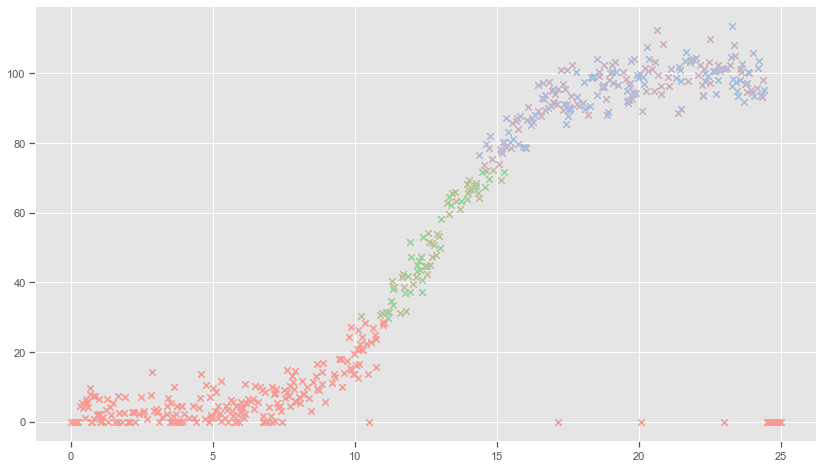

In [22]:
# Machine learning - KMeans.
import sklearn.cluster as skcl
x1 = np.array(df.speed)
x2 = np.array(df.power)
X =  np.vstack([x1, x2]).T
X.size 
# 1000
X.shape
# (500, 2)
# Plots styles.
plt.style.use('ggplot')

# Plot size.
plt.rcParams['figure.figsize'] = (14, 8)
# Plot the data set.

# Plot the data set.
plt.plot(X[:,0], X[:,1], 'x')

# Perform kmeans fitting.
kmeans = skcl.KMeans(n_clusters=3, random_state=0).fit(X)
plt.plot(X[kmeans.labels_ == 0][:,0], X[kmeans.labels_ == 0][:,1], 'gx')
plt.plot(X[kmeans.labels_ == 1][:,0], X[kmeans.labels_ == 1][:,1], 'rx')
plt.plot(X[kmeans.labels_ == 2][:,0], X[kmeans.labels_ == 2][:,1], 'bx')
plt.show()

In [23]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


In [24]:
df.sort_values(by='speed', ascending=False).head()

,speed,power
499,25.000,0.0
498,24.950,0.0
497,24.875,0.0
496,24.850,0.0
495,24.775,0.0


In [25]:
len(df.groupby('speed')) # 490
df.groupby('speed')['power'].agg(['count', 'size', 'nunique'])
len(df.groupby('power')) # 451

df.groupby('power')['speed'].agg(['count', 'size', 'nunique'])
len(df[['speed', 'power']].drop_duplicates()) # 490

500

### Zero values
#### Where do the zero values occur?
- There are 49 datapoints where power value is zero
- There is only 1 datapoint where speed value is zero (also power)
- Ten speed values over 24.4 metres per hour with a corresponding power value of zero
- There are no data points with speeds above 24.4 and power not equal to zero
- Eight data points where speed is less than 8 metres per second and power value is zero
- Four datapoints where speed is greater than 8 and less than 24.4 metres per second and corresponding power values are zero
- 24 datapoints where speed is less than 4 metres per second and power is zero

In [26]:
# the rows where both values are zer0
print(df[(df['speed']==0) & (df['power']==0)].count()) # only 1

speed    1
power    1
dtype: int64


#### 49 observations with zero power values

In [27]:
df[df.power==0].count()

speed    49
power    49
dtype: int64

#### Cut-in speeds between 3 and 4 metres per second
The cut-in speed is typically 7 to 9 mph. (equivalent to 3.13 to 4.02 meters per second).
- 17 observations where speed is less than 3 metres per second

In [28]:
print(f"Zero power values where speed is below 3 metres per second:\n{df[(df.speed <3) & (df.power==0.0)].count()}")
print(f"Zero power values where speed is between 3 and 4 metres per second:\n{df[(df.speed >3) & (df.speed <4) & (df.power==0.0)].count()}")
print(f"Zero power values where speed is between 4 and 7 metres per second:\n{df[(df.speed >4) & (df.speed<7) & (df.power==0.0)].count()}")
print(f"Zero power values where speed is between 7 and 24.4 metres per second:\n{df[(df.speed >7) & (df.speed<24.4) & (df.power==0.0)].count()}")
print(f"Zero power values where speed is above 24.4 metres per second:\n{df[(df.speed>24.4) & (df.power==0.0)].count()}")

Zero power values where speed is below 3 metres per second:
speed    17
power    17
dtype: int64
Zero power values where speed is between 3 and 4 metres per second:
speed    7
power    7
dtype: int64
Zero power values where speed is between 4 and 7 metres per second:
speed    9
power    9
dtype: int64
Zero power values where speed is between 7 and 24.4 metres per second:
speed    6
power    6
dtype: int64
Zero power values where speed is above 24.4 metres per second:
speed    10
power    10
dtype: int64


#### Non-zero power values where speed is less than 3 metres per second:
There are 39 observations where speed is less than the cut-in speed (of between 3 and 4 metres per second) and the corresponding power value is greater than zero. I think these are the tricky ones to predict. There was mention in the one of the articles referenced earlier that while sometimes there might not be enough wind to turn a turbine, the wind energy is not lost as the wind energy can be stored in energy storage systems for later use whenever wind levels are low.

In [29]:
df[(df.speed < 3) & (df.power>0.0)].count() # 39
df[(df.speed < 3) & (df.power==0.0)].count() # 17


speed    17
power    17
dtype: int64

In [30]:
df[(df.speed < 4) & (df.power>0.0)].count() # 56
df[(df.speed < 4) & (df.power==0.0)].count() # 24

speed    24
power    24
dtype: int64

#### Rated speed
At the rated wind speed, the turbine is able to generate electricity at its maximum, or rated, capacity.
The rated speed is usually in the range of 25 to 35 mph. (equivalent to 11.18 to 13.4 metres per second).
This is based on the research above but we don't know the details of the actual wind turbines being used here.
The rated speed for the turbines in this dataset must be greated than this range as they do not reach their maximum capacity until wind speed is greater than 15 metres per second.
The max power value in the dataset is 113.556 kws but there are very few observations in the dataset where power is greater than 110. The power curve for this dataset shows the power values levelling off in and around values between 90 and 100. I need to blow the plot up some more to see the exact values.




#### Power values greater than 100
- 31 power values between 80 and 90
- 95 power values between 90 and 100
- 55  between 100 and 110

In [31]:
print(f"Data points where power is between 80 and 90:\n{df[(df.power>80)&(df.power<90)].count()}")
print(f"Data points where power is between 90 and 100:\n{df[(df.power>90)&(df.power<100)].count()}")
print(f"Data points where power is between 100 and 110:\n{df[(df.power>100)&(df.power<110)].count()}")
print(f"Data points where power greater than 110:\n{df[(df.power>110)].count()}")

Data points where power is between 80 and 90:
speed    31
power    31
dtype: int64
Data points where power is between 90 and 100:
speed    95
power    95
dtype: int64
Data points where power is between 100 and 110:
speed    55
power    55
dtype: int64
Data points where power greater than 110:
speed    2
power    2
dtype: int64


In [32]:
df[df.power>100].count()

speed    57
power    57
dtype: int64

In [33]:
df[(df.speed >11) & (df.speed< 13.4)].count()

speed    49
power    49
dtype: int64

#### Cut-out speeds for safety reasons
At the cut-out wind speed, the turbine shuts down to avoid damage.
There are 10 observations that fall into the cut-out speed range.
There are no datapoints where speed is above the cut-out speed value where power is not zero.

In [34]:
# there are no points in the dataset where speed is greater than 24.4 and power value is not zero
print(f"Speed values above 24.4 metres per second:\n{df[df.speed>24.4].count()}") # 
print(f"Zero power values where speed is above 24.4 metres per second:\n{df[(df.speed > 24.4) & (df.power==0.0)].count()}")

Speed values above 24.4 metres per second:
speed    10
power    10
dtype: int64
Zero power values where speed is above 24.4 metres per second:
speed    10
power    10
dtype: int64


#### Speeds between 7 and 8 metres per second:

In [35]:
df[(df.speed >7) & (df.speed < 8) & (df.power==0.0)].count()

speed    2
power    2
dtype: int64

### Dealing with zero values



After initially trying out the neural network using the complete dataset, the cost did not fall below a certain value and the resulting plots suggested that keeping the zero power values in for the very high values of speed were affecting the calculations. The research showed that there is a cut-out speed between 24 and 25 metres per second for safety reasons.  At the cut-out wind speed, the turbine shuts down to avoid damage. This is enough to justify excluding these observations as we can predict that the power output will be zero when the wind speed exceeds this cut out value. There are only ten observations in the dataset that fall into this range.
We can only predict values for power when the turbines are turned on and therefore maybe the model should only be predicting for values of speed where the turbine is on! 

While there is only one zero value for the speed variable, there are 49 zero values for the power variable. These mostly occur below a certain value of speed but located alongside non-zero power values and there are a few that are associated with medium and higher speed values of speed. Most of the data points in the dataset are unique values. The one datapoint with a zero speed value has a zero power value as expected.

Summary of where the zero power values occur:
- 17 where speed is less than 3 metres per second
- 7 where speed is between 3 and 4 metres per second. This is the cut-in speed
- 9 where speed lies between 4 and 7
- 6 where speed is between 7 and 24.4
- 10 where speed is above 24.4 metres per second. This is the cut-out value.

For now I will drop all observations where speed is greater than the cut-out value of 24.4. 
I will also drop the observations above the cut-in speed of between 3 and 4 metres per second.
I will leave in all the observations where speed is less than the cut-in speed including the zero values.
(Wind turbines generate electricity at wind speeds of 4 – 25 metres per second [123]Wind Energy Basics)

This means that for now I am dropping 25 observations from the dataset where the power values are zero.
Ten observations where the wind speed is greater than the cut-off value; the corresponding power is zero as the turbines are off.
Fifteen observations where wind speed is greater than the cut-in and less than the cut-out and the power is zero. Assume these represent points where the turbines are turned off for maintenance or other reasons.

In [36]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
# https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
#df.drop(df.loc[(df.speed>24.4)].index, inplace=True)

In [37]:
# make a copy of the dataframe
dfx = df.copy()

In [38]:
dfx.loc[(dfx.speed > 4)&(dfx.power == 0)].count()

speed    25
power    25
dtype: int64

In [39]:
dfx.drop(dfx.loc[(df.speed > 4)&(dfx.power == 0)].index, inplace=True)

In [40]:
dfx.describe()

,speed,power
count,475.000000,475.000000
mean,12.440971,50.541667
std,7.101231,41.171815
min,0.000000,0.000000
25%,6.293500,6.737500
50%,12.538000,47.282000
75%,18.531500,94.017500
max,24.399000,113.556000


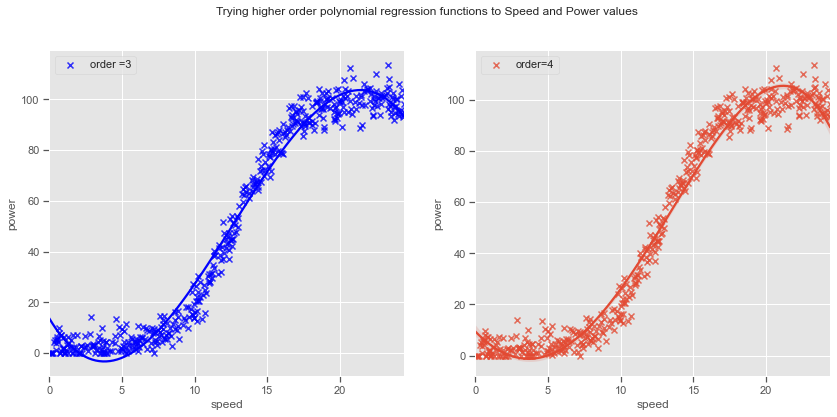

In [41]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))
x = "speed"
y = "power"

sns.regplot(x="speed", y="power", data=dfx, order=3, ax=axes[0], label="order =3", ci=False, color="blue", marker="x"); axes[0].legend()
sns.regplot(x="speed", y="power", data=dfx, order=4, ax=axes[1], label = "order=4",marker='x'); axes[1].legend()
plt.legend()
plt.suptitle("Trying higher order polynomial regression functions to Speed and Power values")
plt.show()

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])

## Machine Learning.

The goal of the project is to predict wind power from wind speed and therefore this problem falls into supervised learning. 
>Supervised learning is where you have input variables (x) and an output variable (Y) and you use an algorithm to learn the mapping function from the input to the output [Machine Learning Mastery](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/)[]

- Regression: Predicting a continuous-valued attribute associated with an object.
I had a look at the regression plots earlier, simple linear regression does not adequately model the relationship between the wind and speed values over the entire dataset while higher order polynomials captured more of the relationship. The simple linear model clearly underfit the data. The correlation statistics did show a high correlation between the variables with a value of 0.853778 but this doesn't mean the relationship is linear.
There were large sections of the dataset that were either under the regression line or above the regression line.
The higher order polynomials did not fit the data perfectly though. The cubic polynomial fits the data better and the fourth order polynomial does seem to be even better for the datapoints at the lower end of wind speed values. However it is important not to overfit the data either as then the model will not capture the general trend of the data.

- [Polynomial Regressions - extending linear models](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)


>One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

A simple linear regression can be extended by constructing polynomial features from the coefficients.
`PolynomialFeatures` transforms an input data matrix into a new data matrix of a given degree. I will use a third degree polynomial here as the data earlier suggested this. In addition there was of this in the research above that 
*The typical power curves have an s-shape where at wind speeds less than rated the energy capture is approximately proportional to $U^3$* where ($U=\bar{\mu}$) is the 10 minute averaged wind speeds.

Adding an X-squared to the data allows us to check if there is a quadratic relationship in the data. Adding an x-cubed allows us to check if there is a cubic relationship in the data. This has a snake-shaped curve. 
Adding polynomials to the regression is like multiple linear regression, as you are adding extra variables.

- [Polynomial regression with scikit-learn](https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2)
- [How to fit a polynomial curve to data using scikit-learn](https://stackoverflow.com/questions/32660231/how-to-fit-a-polynomial-curve-to-data-using-scikit-learn/32660433)


In [129]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import numpy as np
dfx
# 3 is the best from the earlier seaborn plots

# otherwise I end up with a column of zeros 
poly = PolynomialFeatures(degree=3, include_bias=False)

### Split data into training and test sets

In [130]:

# split into input and output columns

X, y = dfx.values[:, :-1], dfx.values[:, -1:]
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]

(356, 1) (119, 1) (356, 1) (119, 1)


#### Transform the features of x 
Once transformed they can be used with any linear model. I will apply to the training data only here.
Note I will save the features to keep my training set for later use with the neural network model.

In [131]:
# convert the inputs into a new set of variables, save as X_train_p3 to leave X_train untouched for later use
X_train_poly3 = poly.fit_transform(X_train)

In [132]:
X_train_poly3

array([[8.08300000e+00, 6.53348890e+01, 5.28101908e+02],
       [2.47700000e+00, 6.13552900e+00, 1.51977053e+01],
       [1.57660000e+01, 2.48566756e+02, 3.91890348e+03],
       ...,
       [6.18100000e+00, 3.82047610e+01, 2.36143628e+02],
       [2.25200000e+00, 5.07150400e+00, 1.14210270e+01],
       [9.43400000e+00, 8.90003560e+01, 8.39629359e+02]])

In [133]:
# also need to transform the test data 
X_test_poly3 = poly.fit_transform(X_test)

Now linear regression can be implemented that can be thought of multiple linear regression as we have added new variables in the form of x squared and x cubed.

In [134]:
# call the linear regression model
model_poly3 = linear_model.LinearRegression()

In [135]:
# fit to the training data
model_poly3.fit(X_train_poly3, y_train)

LinearRegression()

In [136]:
# predict on the transformed test data
poly3_predictions = model_poly3.predict(X_test_poly3)

#### Get the coefficients

In [137]:
# get the coefficiets
model_poly3.coef_

array([[-9.69965794,  1.49732   , -0.03967732]])

In [138]:
# get the intercept
model_poly3.intercept_

array([14.35877751])

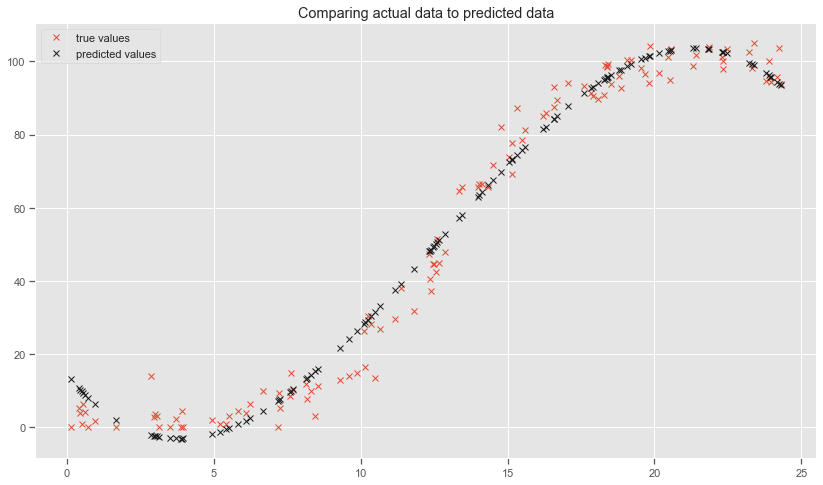

In [139]:
plt.title('Comparing actual data to predicted data')
plt.plot(X_test, y_test, 'x', label="true values")
plt.plot(X_test, poly3_predictions, 'kx', label="predicted values")
plt.legend()

plt.show()

### Evaluate the model

- [sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
The coefficient of determination $R^2$ is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

The model can be evaluated using the mean squared error. It calculates the average distance our data points are from the model.  
The mean squared error could be further lowered by adding extra polynomials to the model. However you are then in danger of overfitting the model where the model will fail to recognise the general trend. The simple linear model cleared underfit the data. The seaborn regression plots with a 4th order polynomial earlier did show a slightly better fit for speed values under 5 metres per second whereas the 3rd order polynomial is underpredicting and overfitting for sections of the curve. However it does not seem to be a huge improvement so I will leave the regression as is and move on.
The root mean squared error is the square root of the average of squared differences between prediction and actual observation.  It is a standard way to measure the error of a model in predicting quantitative data.

In [140]:
from sklearn.metrics import mean_squared_error, r2_score

In [141]:
# The coefficients
print('Coefficients: \n', model_poly3.coef_)

Coefficients: 
 [[-9.69965794  1.49732    -0.03967732]]


In [142]:
print('Mean squared error: %.2f' % mean_squared_error(y_test,poly3_predictions ))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, poly3_predictions))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test,poly3_predictions )))

Mean squared error: 33.32
Coefficient of determination: 0.98
Root Mean Squared Error: 5.77


In [143]:
# Predicting a new result with Polymonial Regression
# need to transform the data to be predicted
model_poly3.predict(poly.fit_transform([[20]]))

array([[101.8750371]])

In [144]:
# Predicting a new result with Polymonial Regression
model_poly3.predict(poly.fit_transform([[24.4]]))

array([[92.74766278]])

In [145]:
# Predicting a new result with Polymonial Regression
model_poly3.predict(poly.fit_transform([[0]]))

array([[14.35877751]])

### Save the model for use in the Web application

In [146]:
# Predicting a new result with Polymonial Regression
model_poly3.predict(poly.fit_transform([[3]]))

array([[-2.33560405]])

In [147]:
from joblib import dump, load
dump(model_poly3, 'model_poly3.joblib') 

['model_poly3.joblib']

In [152]:
dump(model_poly3, 'model_poly3.pkl') 

['model_poly3.pkl']

### Trying to get the right input for predicting in the web app
It seems I have 4 coefficients instead of 3 which I think includes a constant 1. See how to exclude this

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
So I will redo and exclude the bias term. set it to false.

In [153]:
wind12 = poly.fit_transform([[12]])
wind12

array([[  12.,  144., 1728.]])

In [154]:
model_poly3.predict(wind12)

array([[45.01454843]])

In [155]:
win12 = [[12, 12**2, 12**3]]
win12 =np.array(win12)

In [151]:
model_poly3.predict(win12)

array([[45.01454843]])

In [156]:
wind3 = [[3, 3**2, 3**3]]
wind3 = np.array(wind3)
model_poly3.predict(wind3)

array([[-2.33560405]])

The polynomial curve does quite a good job but similarly to the MLP below, it predicts power values for values over 24.4 which is the cut-off range. 
Also the transformation has to be taken into account when taking in new values from the end user.

Machine learning is the science of getting computers to act without being explicitly programmed.
- https://www.investopedia.com/terms/n/neuralnetwork.asp#:~:text=A%20neural%20network%20is%20a,organic%20or%20artificial%20in%20nature.
- https://en.wikipedia.org/wiki/Artificial_neural_network

- https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414

>Neural nets are a means of doing machine learning, in which a computer learns to perform some task by analyzing training examples.
>Modeled loosely on the human brain, a neural net consists of thousands or even millions of simple processing nodes that are densely interconnected. Most of today’s neural nets are organized into layers of nodes, and they’re “feed-forward,” meaning that data moves through them in only one direction. An individual node might be connected to several nodes in the layer beneath it, from which it receives data, and several nodes in the layer above it, to which it sends data.
>To each of its incoming connections, a node will assign a number known as a “weight.” When the network is active, the node receives a different data item — a different number — over each of its connections and multiplies it by the associated weight. It then adds the resulting products together, yielding a single number. If that number is below a threshold value, the node passes no data to the next layer. If the number exceeds the threshold value, the node “fires,” which in today’s neural nets generally means sending the number — the sum of the weighted inputs — along all its outgoing connections.
When a neural net is being trained, all of its weights and thresholds are initially set to random values. Training data is fed to the bottom layer — the input layer — and it passes through the succeeding layers, getting multiplied and added together in complex ways, until it finally arrives, radically transformed, at the output layer. During training, the weights and thresholds are continually adjusted until training data with the same labels consistently yield similar outputs.
[Mit News](https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414)[nn1]

## Machine Learning - Neural Networks

Some notes from the lectures:
A dataset contains variables, some inputs and outputs. Categorical data, text and image data must first be encoded into floating point numbers. Outputs can be reverse decoded later. Weights are applied to each connection between layers, low weights near 0 meaning that the route is not important while higher values mean this route is important. 
Some of the dataset can be held back for testing. 
Neural networks have several layers. The input layer is really a non-layer of neurons with just the inputs. You just provide the input layer to the neural network and this is really the only place the input comes into it.

The hidden layers and output layers have proper neurons.
The weights and bias are the paramters of the model, you can tweak them to get the neural network to perform better. Often the initial weights might be set to small random values between 0 and 1. 
Neural networks cares more about the connections between the nodes than the actual nodes themselves. Looks at the signal times the weights for each of the inputs. `w * x` for each input. 

The bias significes how important something is and is just a number on top of weight times input for each neuron. 
With neural networks you want to get a high value assigned to the correct output. If the neural network misclassifies an output label then you just feed it back into the algorithm, the weights are changed a little so that the correct output is predicted the next time. It will keep changing until it gets the correct output. 
Starts out with random values for the weights. These are updated slowly over time to get towards the expected output.

Gradient descent is the algorithm through which the weights are updated. Stochastic gradient descent (`sgd`).
Each output from each neuron is the same but when the different weights are applied, what is received by the nodes in the next layer are different to what left the nodes on the previous layer.
The loss is the cost function, often the MSE mean squared error.

A linear function y = x is just a simple function where you give it a single input and expect the same output.

Once the neural network is trained and is stable, you can then take a new input, a new datapoint it was not trained on and the neural network should correctly classify it.
the complexity in neural networks comes from the number of operations involved especially when there are many layers.

---

https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/
Taking notes from another machine learning mastery tutorial.

### The 5-step Deep Learning Model Life-Cycle
A model has a life-cycle with 5 steps:
1. Define the model: 
Select the type of model and choose the architecture or network topology. Define the number of layers, configure each layer with a number of nodes and activation function, connect the layers together into a cohesive model.

2. Compile the model

    * This requires selecting a **loss function** that you want to optimise such as mean squared error and to select an algorithm to perform the **optimisation** procedure such as stochastic gradient descent or a modern variation of this called Adam. Also you can select the **performance metrics**  to keep track of during the model training process.
    * Call a function to compile the model with the selected configuration to prepare the appropriate data structures required for the efficient use of the selected model. 
    * The optimizer can be specified as a string for a known optimizer class such as `sgd` for stochastic gradient descent or else you can configure an instance of the optimizer class to use. See [optimizer classes](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

    * `sgd` - Gradient descent (with momentum) optimizer. The default learning rate is 0.01
    The update rule is ` w = w - learning_rate * g` for parameter `w` with  gradient `g` when momentum is 0.
    * 

    *Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam]
    *  The `learning_rate` defaults to 0.001 in the Adam optimizer. 

    - Loss Functions: class MeanSquaredError: Computes the mean of squares of errors between labels and predictions.
    The mean squared error is the one I will be using. There are many more listed in the [keras losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) documentation.
    
    * Metrics to evaluate predictions such as `Accuracy`  which calculates how often predictions equal labels, `AUC` computes the approximate area under the curve,  `FalseNegatives` which calculates the number of false negatives and `FalsePositives` calculates the number of false positives, `Precision` computes the precision of the predictions with respect to the labels. 
    There are many more [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) which I will come back when I get to that point...

3. Fit the model

To fit the model you need to select the training configuration such as the number of epochs which are loops through the training dataset. The batch size is the number of samples in an epoch used to estimate model error.
(By passing in say 10 at a time instead of 1 at a time can have a smoothing effect)

Training applies the chosen optimization algorithm to minimize the chosen loss function and updates the model using the backpropagation of error algorithm. This can be slow depending on the complexity of the model, the size of the training dataset and the hardware being used.

There is another machine learning article here on [the importance of batch sizes](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)



4. Evaluate the model

This is where the holdout dataset comes into play, data that is not used in the training of the model so you can get an unbiased estimate of the performance of the model when making predictions on new data.

5. Make predictions
This is the final stage of the life cycle where you take values that you don't have target values and make a prediction.

### Sequential model
A **sequential** model adds layers to the model one by one in a linear manner, from input to output.
    The visible layer of the network is defined by the input shape argument on the first hidden layer. In the wind dataset this will be `(1,)` - the model will expect the input for one sample to be a vector of 1 number.
`model.add()` is used to add each layer.

There is also a functional model which is more complex but more flexible. It involves explicitly connecting the output of one layer to the input of another layer. Each connection is specified. I will be using the sequential model for this project.

###  Develop Multilayer Perceptron Models

A Multilayer Perceptron model (MLP) is a standard fully connected neural network model. It is made up of one or more (dense) layers of nodes where each node is connected to all outputs from the previous layer and the output of each node is connected to all the inputs for the nodes in the next layer. This model is suitable for tabular data and can be used for three predictive modeling problems being binary classification, multiclass classification, and regression. 
The tutorial demostrates using MLP for each of the three predictive modeling problems.



### Train a model

- A **layer** is a simple input-output transformation.
- A **model** is a directed acyclic graph of layers. It is like a bigger layer consisting of many sub-layers that can be trained via exposure to data.
- Define the input layer, then chain layer transformations on top of the inputs until the final output.
- Once the layers have been defined that turn the inputs into outputs, instantiate a `model` object.
- A Sequential model is created by passing  a list of layers to the Sequential constructor
    `model = keras.Sequential` or by incrementally adding the layers using the `add()` method.
- All layers in Keras need to know the shape of their inputs in order to be able to create weights.
The shape of the weights depends on the shape of their inputs.
- The `Input` object is not a layer. Pass the input_shape() argument to the first layer.
- Specify an optimizer and an a loss function using the `compile()` step.
- Once the model has been compiled, fit the model to the data using `fit()`.
- Two parameters need to be specified alongside the data, the `batch_size`  and the number of `epochs` (iterations on the data).
- The `fit` call returns a history object which records what happens over the course of the training.
- The `history.history` dict contains per-epoch timeseries of metrics values.
- Validation data can be passed to `fit()` to monitor the validation loss & validation metrics which get reported at the end of each epoch.
- After `fit()` you can evaluate the performance and generate predictions on new data using `evaluate()`.
`loss, acc = model.evaluate(val_dataset)`
`print("loss: %.2f" % loss)
print("acc: %.2f" % acc)`
- Generate numPy arrays of predictions using `predict()`.
predictions = model.predict(val_dataset)

When passing data to the built-in training loops of a model, NumPy arrays can be used if the data is small and fits in memory or `tf.data.Dataset` objects. The dataset here is only 500 rows.


https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/ demonstrates a fully connected network structure with three layers.

Create a Sequential Model and  add layers one at a time until happy with the network architecture. A sequential neural network is built up in sequential layers.

The first thing is to ensure the input layer has the right number of input features. You provide the input layer to the model
The dataset here has only a single input feature which is wind speed. How to determine the correct number of layers to use? According to the tutorial its a matter of trial and error really. Generally you need a network large enough to capture the structure of the problem.

Fully connected layers are defined using the `Dense` class.  Dense refers to the layer being densely connected to the previous layer. Every node in the previous layer is connected to everything in the current layer.


The number of neurons or nodes in the layer as the first argument and specify the activation function using the `activation` argument. The demo uses the `rectified linear unit` activation function referred to as ReLU on the first two layers and the Sigmoid function in the output layer. As far as I recall Ian recommended using just the Sigmoid activation function. According to the tutorial, Sigmoid and Tanh activation functions were the preferred choice  for all layers before but that these days better performance is achieved using the ReLU activation function. I can try one or the other.  A `Sigmoid` layer is used on the outer layer to ensure the network output is between 0 and 1. (This problem though is not looking to classify the data into one of two classes.).
The input shape is 1 as there is only 1 input variable. (input_dim=1 or input_shape=(1,))
The shape of the input to the model is defined as an argument on the first hidden layer. The first line of code that adds the first Dense layer does 2 things, defines the input or visible layer and the first hidden layer.

#### compile
Once the model is defined, it can be compiled or built. We specify the learning rate and the loss function which we want to minimise.

When compiling, some additional properties are required when training the network. Training a network means finding the best set of weights to map inputs to outputs in our dataset. The loss function must be specified
>We must specify the loss function to use to evaluate a set of weights, the optimizer is used to search through different weights for the network and any optional metrics we would like to collect and report during training.

The tutorial uses cross entrophy as the loss argument as it is looking at a binary classification problem. We are to stick with mean squared error I think.
>The optimizer is defined below as the efficient stochastic gradient descent algorithm “adam“. This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.

https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0
Here I am reading through the article referenced, making notes and some paraphrasing. I will reference properly later.

An artificial neuron calculates a weighted sum of its input, adds a bias and then decides whether it should be fired or not. $ Y = \sum{(\text{weight} * \text{input})} + \text{bias}$
The value of Y can be anything from -infinity to + infinity. The neuron does not really know the bounds of the value. So how do we decide whether the neuron should fire or not? This is where the activation functions come in. The activation function will check the Y value produced by the neuron and decide whether outside connections should consider this neuron as activated (fired) or not.

Consider a threshold based activation function. If the value of Y is above a certain value then it could declare it as activated, otherwise not. In this case the output is 1 (activated) when the value is greater than than the threshold and 0 otherwise. This is a step function. There are drawbacks to using this method as an activation function for neural networks though when the response is not a binary yes or no.

A linear activation function A = cx is a straight line function where activation is proportional to input ( which is the weighted sum from neuron ). In this way it will give a range of activations rather than just binary activations. We can connect some neurons and if more than one fire then we could take the max and decide based on that.

The derivative w.r.x is c which means that the gradient has no relationship with X. The descent is going to be on a constant gradient. If there is an error in prediction the changes made by back propagation is constant and not depending on the change in input delta(x).
Another problem concerns the connected layers where each layer is activated by a linear function. 
That activation in turn goes into the next level as input and the second layer calculates weighted sum on that input and it in turn, fires based on another linear activation function.
No matter how many layers we have, if all are linear in nature, the final activation function of last layer is nothing but just a linear function of the input of first layer. Therefore two or more layers can be replaced by a single layer. The whole network then is equivalent to  a single layer with linear activation.

Thw sigmoid function is smooth and looks somewhat like a step function. It is nonlinear in nature and therefore combinations of layers are also non-linear which means that layers can be stacked. It will also give non binary activations unlike the step function. It has a smooth gradient.

Between X values -2 to 2, the Y values are very steep.This means that any small changes in the values of X in that region will cause values of Y to change significantly.This means this function has a tendency to bring the Y values to either end of the curve.
It tends to bring the activations to either side of the curve making clear distinctions on prediction. Another advantage over linear function is that the output of the activation function is always going to be in range (0,1) compared to (-inf, inf) of linear function and therefore the activations are bound in a range. 
Sigmoid functions are one of the most widely used activation functions today. The problems with them is that towards either end of the sigmoid function, the Y values tend to respond very less to changes in X. This means that the gradient at that region is going to be small. It gives rise to a problem of “vanishing gradients”. When the activations reach near the “near-horizontal” part of the curve on either sides, the gradient is small or has vanished ( cannot make significant change because of the extremely small value ). The network refuses to learn further or is drastically slow ( depending on use case and until gradient /computation gets hit by floating point value limits ). There are ways to work around this problem and sigmoid is still very popular in classification problems.
The article also looked at the Tanh activation functions which is a scaled sigmoid function and the ReLu function which gives an output x if x is positive and 0 otherwise. These are both non-linear functions.

The article finishes by suggesting how to choose the correct activation function. 
When you know the function you are trying to approximate has certain characteristics, you can choose an activation function which will approximate the function faster leading to faster training process. For example, a sigmoid works well for a classifier 

### Import required packages

In [198]:
# Neural networks.
import tensorflow.keras as kr
print(kr.__version__)

# Numerical arrays
import numpy as np

# Data frames.
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
# splitting the data into training and test 
from sklearn.model_selection import train_test_split



2.4.0


### The data:

In [160]:
# mlp for regression

from pandas import read_csv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
path = 'https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv'
data = dfx

In [89]:
# already done this in dfx
# drop some of the outliers
#df.drop(df.loc[(df.speed>24.4)].index, inplace=True)

In [90]:
dfx.describe()

,speed,power
count,475.000000,475.000000
mean,12.440971,50.541667
std,7.101231,41.171815
min,0.000000,0.000000
25%,6.293500,6.737500
50%,12.538000,47.282000
75%,18.531500,94.017500
max,24.399000,113.556000


### The data split into training and test sets

- df is the original dataset with all 500 datapoints,
- dfx is another copy where I dropped some of the the rows with zero power when the speed is over a certain value.
The ideal machine-learning model is end to end and therefore the preprocessing should be part of the model as much as possible to make the model portable for production.
I don't see anything in the Keras documentation for splitting dataset into training and test sets so I will use scikit-learn. This should not make any difference as it is only to split the data. However I initially followed some tutorials that used scikit-learn for scaling or normalising data and now I see that this will be a problem on the web app as the data taken in would have to have the scaling or normalisation applied as the training data. Keras does have some preprocessing layers including the `Normalization` layer for feature normalization.
The model I used first below was a multi perceptron neural network on the unscaled data. The predictions were not bad. I then used the `preprocessing.MinMaxScaler()` from scikit-learn below but I am going to use the Normalization layer from tensorflow.keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [47]:
dfx.values.shape

(475, 2)

### First without normalisation
Here the dataset has been split into a training and test set of input and output variables.

In [199]:

# split into input and output columns

X, y = dfx.values[:, :-1], dfx.values[:, -1:]
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]

(356, 1) (119, 1) (356, 1) (119, 1)


In [200]:
# Train a model
model = kr.models.Sequential()
model.add(kr.layers.Dense(60, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
#model.add(kr.layers.BatchNormalization())
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

### Compile the model

In [201]:
# 
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


The first dense layer has 100 parameters consisting of 60 neurons and 60 bias terms while the second dense layer is the output layer which has only one neuron with 1 bias and 60 inputs from the previous layer. 

#### Train the model on the data
Following the machine mastery tutorial, I have added in the validation data.

In [202]:
# fit the model
#history=model.fit(X_train, y_train, validation_data =(X_test, y_test),epochs=500, batch_size=10) #verbose=0
history=model.fit(X_train, y_train, validation_data =(X_test, y_test),epochs=500, batch_size=10) #verbose=0

Epoch 1/500
36/36 [==============================] - 0s 4ms/step - loss: 4294.2529 - val_loss: 4528.9326
Epoch 2/500
36/36 [==============================] - 0s 2ms/step - loss: 4119.2817 - val_loss: 4335.1411
Epoch 3/500
36/36 [==============================] - 0s 2ms/step - loss: 3924.0884 - val_loss: 4100.4028
Epoch 4/500
36/36 [==============================] - 0s 2ms/step - loss: 3687.3147 - val_loss: 3823.6797
Epoch 5/500
36/36 [==============================] - 0s 2ms/step - loss: 3431.3928 - val_loss: 3565.0425
Epoch 6/500
36/36 [==============================] - 0s 2ms/step - loss: 3215.2869 - val_loss: 3356.0125
Epoch 7/500
36/36 [==============================] - 0s 2ms/step - loss: 3040.9551 - val_loss: 3181.3293
Epoch 8/500
36/36 [==============================] - 0s 2ms/step - loss: 2892.9316 - val_loss: 3038.8293
Epoch 9/500
36/36 [==============================] - 0s 2ms/step - loss: 2768.6716 - val_loss: 2909.1125
Epoch 10/500
36/36 [==============================] - 0

36/36 [==============================] - 0s 2ms/step - loss: 273.4964 - val_loss: 274.6518
Epoch 80/500
36/36 [==============================] - 0s 2ms/step - loss: 265.1360 - val_loss: 265.8104
Epoch 81/500
36/36 [==============================] - 0s 2ms/step - loss: 257.0031 - val_loss: 257.3533
Epoch 82/500
36/36 [==============================] - 0s 2ms/step - loss: 249.7163 - val_loss: 249.4925
Epoch 83/500
36/36 [==============================] - 0s 2ms/step - loss: 242.7940 - val_loss: 241.6751
Epoch 84/500
36/36 [==============================] - 0s 2ms/step - loss: 235.1017 - val_loss: 234.5696
Epoch 85/500
36/36 [==============================] - 0s 2ms/step - loss: 229.2678 - val_loss: 227.2328
Epoch 86/500
36/36 [==============================] - 0s 2ms/step - loss: 221.5821 - val_loss: 220.6856
Epoch 87/500
36/36 [==============================] - 0s 2ms/step - loss: 215.5275 - val_loss: 214.0699
Epoch 88/500
36/36 [==============================] - 0s 2ms/step - loss: 210

Epoch 158/500
36/36 [==============================] - 0s 2ms/step - loss: 76.4568 - val_loss: 71.7737
Epoch 159/500
36/36 [==============================] - 0s 2ms/step - loss: 75.7523 - val_loss: 70.3901
Epoch 160/500
36/36 [==============================] - 0s 2ms/step - loss: 75.5478 - val_loss: 70.3176
Epoch 161/500
36/36 [==============================] - 0s 2ms/step - loss: 75.5850 - val_loss: 69.6753
Epoch 162/500
36/36 [==============================] - 0s 2ms/step - loss: 74.4963 - val_loss: 69.7045
Epoch 163/500
36/36 [==============================] - 0s 2ms/step - loss: 74.0844 - val_loss: 68.9230
Epoch 164/500
36/36 [==============================] - 0s 2ms/step - loss: 73.9333 - val_loss: 68.4541
Epoch 165/500
36/36 [==============================] - 0s 2ms/step - loss: 73.8182 - val_loss: 68.6946
Epoch 166/500
36/36 [==============================] - 0s 2ms/step - loss: 73.1669 - val_loss: 68.7160
Epoch 167/500
36/36 [==============================] - 0s 2ms/step - loss

36/36 [==============================] - 0s 2ms/step - loss: 26.9589 - val_loss: 25.4144
Epoch 317/500
36/36 [==============================] - 0s 2ms/step - loss: 26.8753 - val_loss: 25.3020
Epoch 318/500
36/36 [==============================] - 0s 2ms/step - loss: 26.7374 - val_loss: 24.9256
Epoch 319/500
36/36 [==============================] - 0s 2ms/step - loss: 26.6388 - val_loss: 24.6497
Epoch 320/500
36/36 [==============================] - 0s 1ms/step - loss: 26.6474 - val_loss: 24.6397
Epoch 321/500
36/36 [==============================] - 0s 2ms/step - loss: 26.3780 - val_loss: 24.7216
Epoch 322/500
36/36 [==============================] - 0s 2ms/step - loss: 26.4270 - val_loss: 25.0477
Epoch 323/500
36/36 [==============================] - 0s 2ms/step - loss: 26.1495 - val_loss: 24.8354
Epoch 324/500
36/36 [==============================] - 0s 2ms/step - loss: 26.1114 - val_loss: 24.8902
Epoch 325/500
36/36 [==============================] - 0s 2ms/step - loss: 26.0227 - va

36/36 [==============================] - 0s 3ms/step - loss: 19.2144 - val_loss: 18.8277
Epoch 475/500
36/36 [==============================] - 0s 3ms/step - loss: 18.7410 - val_loss: 18.1718
Epoch 476/500
36/36 [==============================] - 0s 2ms/step - loss: 18.5636 - val_loss: 18.4732
Epoch 477/500
36/36 [==============================] - 0s 3ms/step - loss: 18.7427 - val_loss: 18.8299
Epoch 478/500
36/36 [==============================] - 0s 3ms/step - loss: 18.6542 - val_loss: 19.0083
Epoch 479/500
36/36 [==============================] - 0s 2ms/step - loss: 18.6064 - val_loss: 17.7874
Epoch 480/500
36/36 [==============================] - 0s 3ms/step - loss: 18.5134 - val_loss: 19.8538
Epoch 481/500
36/36 [==============================] - 0s 2ms/step - loss: 18.9950 - val_loss: 18.3054
Epoch 482/500
36/36 [==============================] - 0s 3ms/step - loss: 18.7212 - val_loss: 18.1769
Epoch 483/500
36/36 [==============================] - 0s 3ms/step - loss: 18.5791 - va

### Evaluate the model

In [205]:
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 18.151, Test: 17.986


### Plotting the learning curve

Back to the https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/ tutorial. The next section looks at plotting model learning curves which plot the performance of the neural network model over time. It helps determine if the model is learning well and whether it is underfitting or overfitting the training set.To do this you need to update the call to to the `fit` function to include a reference to a validation dataset which is a portion of the training dataset not used to fit the model but instead used to evaluate the performance of the model during training. The fit function will then return a history object containing a trace of performance metrics recorded at the end of each training epoch. A learning curve is a plot of the loss on the training dataset and the validation dataset.
history = model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=0, validation_split=0.3)
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(history.history['loss'], 'r.',label='train')
plt.plot(history.history['val_loss'], 'b.',label='val')
plt.legend()
plt.show()

Learning curves of mean squared error  on the train and test set at the end of each training epoch are graphed below using line plots. These learning curves give an indication of the dynamics while learning the model.
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

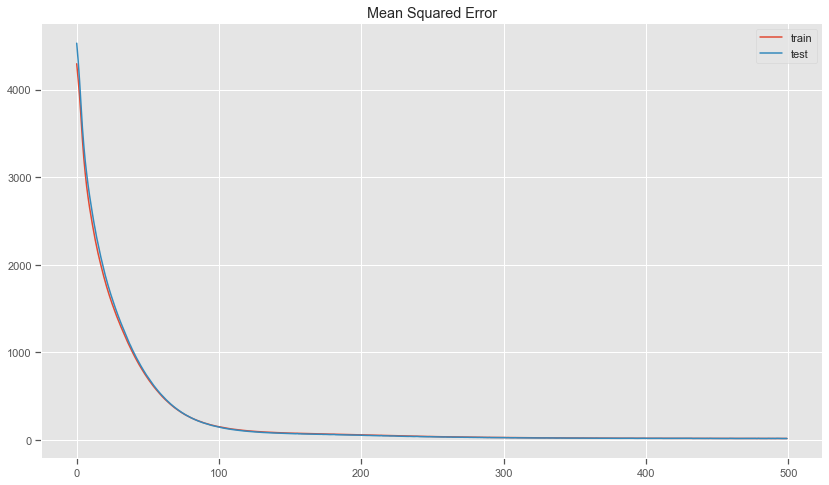

In [204]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Predictions
Run each x value through the neural network.

In [206]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [158]:
#model.predict(X_test)

In [207]:
model_predictions = model.predict(X_test)

### Compare actual data to predictions on test set

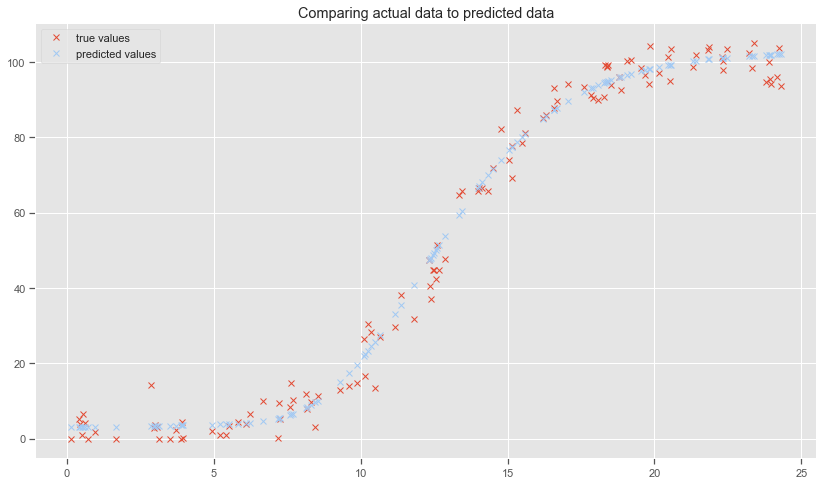

In [249]:
plt.title('Comparing actual data to predicted data')
plt.plot(X_test, y_test, 'x', label="true values")
plt.plot(X_test, model_predictions, 'bx', label="predicted values")

plt.legend()
plt.show()

In [211]:
model.predict([20])

array([[98.45761]], dtype=float32)

### Problem!

Because I took out the values over 24.4 where all the power values were zero, the model is predicting a power value that is incorrect so I need to take this into account in the prediction web app. 
Also it is predicting a power value when wind speed is zero so this is also incorrect.
So here below I experimented by using the entire dataset with the same model and to no avail.
Maybe if I add extra layers this might help...

Overall the model is better at predicting power for the lower values of wind speed than the 3rd order polynomial regression model .

In [212]:
model.predict([3])

array([[3.2875783]], dtype=float32)

In [213]:
model.predict([24.5])

array([[102.088715]], dtype=float32)

In [214]:
model.predict([8])

array([[7.646248]], dtype=float32)

In [215]:
model.predict([23.5])

array([[101.71444]], dtype=float32)

In [216]:
model.predict([0])

array([[3.0309455]], dtype=float32)

In [217]:
model.predict([24.4])

array([[102.05726]], dtype=float32)

### Save the model for use in the web app

In [224]:
model.save('model.h5')

#### Adding in another layer:

In [218]:
# Train a model
model2 = kr.models.Sequential()
model2.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
#model.add(kr.layers.BatchNormalization())
model2.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model2.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

In [219]:
# 
model2.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [220]:
history=model2.fit(X_train, y_train, validation_data =(X_test, y_test),epochs=500, batch_size=10) #verbose=0

Epoch 1/500
36/36 [==============================] - 0s 4ms/step - loss: 4024.6409 - val_loss: 4180.9771
Epoch 2/500
36/36 [==============================] - 0s 2ms/step - loss: 3771.8252 - val_loss: 3944.7280
Epoch 3/500
36/36 [==============================] - 0s 2ms/step - loss: 3581.7332 - val_loss: 3778.4614
Epoch 4/500
36/36 [==============================] - 0s 2ms/step - loss: 3445.3428 - val_loss: 3642.8435
Epoch 5/500
36/36 [==============================] - 0s 2ms/step - loss: 3333.3154 - val_loss: 3527.8843
Epoch 6/500
36/36 [==============================] - 0s 3ms/step - loss: 3234.5735 - val_loss: 3429.4871
Epoch 7/500
36/36 [==============================] - 0s 2ms/step - loss: 3147.4272 - val_loss: 3338.3223
Epoch 8/500
36/36 [==============================] - 0s 2ms/step - loss: 3066.5386 - val_loss: 3251.7913
Epoch 9/500
36/36 [==============================] - 0s 2ms/step - loss: 2988.6172 - val_loss: 3169.0166
Epoch 10/500
36/36 [==============================] - 0

Epoch 79/500
36/36 [==============================] - 0s 4ms/step - loss: 261.2628 - val_loss: 274.3331
Epoch 80/500
36/36 [==============================] - 0s 2ms/step - loss: 249.0735 - val_loss: 259.3979
Epoch 81/500
36/36 [==============================] - 0s 4ms/step - loss: 236.7438 - val_loss: 247.5428
Epoch 82/500
36/36 [==============================] - 0s 3ms/step - loss: 225.4797 - val_loss: 237.2946
Epoch 83/500
36/36 [==============================] - 0s 2ms/step - loss: 214.3448 - val_loss: 224.9501
Epoch 84/500
36/36 [==============================] - 0s 2ms/step - loss: 204.3270 - val_loss: 213.6035
Epoch 85/500
36/36 [==============================] - 0s 2ms/step - loss: 191.6381 - val_loss: 201.6855
Epoch 86/500
36/36 [==============================] - 0s 2ms/step - loss: 180.5807 - val_loss: 188.6526
Epoch 87/500
36/36 [==============================] - 0s 2ms/step - loss: 169.8555 - val_loss: 177.6272
Epoch 88/500
36/36 [==============================] - 0s 2ms/ste

36/36 [==============================] - 0s 3ms/step - loss: 16.7814 - val_loss: 16.2641
Epoch 238/500
36/36 [==============================] - 0s 3ms/step - loss: 16.8619 - val_loss: 17.8692
Epoch 239/500
36/36 [==============================] - 0s 3ms/step - loss: 16.8167 - val_loss: 16.0270
Epoch 240/500
36/36 [==============================] - 0s 2ms/step - loss: 16.4766 - val_loss: 17.0405
Epoch 241/500
36/36 [==============================] - 0s 2ms/step - loss: 16.6302 - val_loss: 16.8732
Epoch 242/500
36/36 [==============================] - 0s 2ms/step - loss: 16.6370 - val_loss: 16.4374
Epoch 243/500
36/36 [==============================] - 0s 2ms/step - loss: 16.4031 - val_loss: 16.1113
Epoch 244/500
36/36 [==============================] - 0s 4ms/step - loss: 16.5640 - val_loss: 17.2452
Epoch 245/500
36/36 [==============================] - 0s 3ms/step - loss: 16.7039 - val_loss: 16.4494
Epoch 246/500
36/36 [==============================] - 0s 3ms/step - loss: 16.6690 - va

36/36 [==============================] - 0s 2ms/step - loss: 16.4492 - val_loss: 17.0307
Epoch 396/500
36/36 [==============================] - 0s 2ms/step - loss: 16.6802 - val_loss: 16.3107
Epoch 397/500
36/36 [==============================] - 0s 2ms/step - loss: 16.4843 - val_loss: 16.1946
Epoch 398/500
36/36 [==============================] - 0s 2ms/step - loss: 16.8617 - val_loss: 16.2418
Epoch 399/500
36/36 [==============================] - 0s 2ms/step - loss: 16.4759 - val_loss: 17.4980
Epoch 400/500
36/36 [==============================] - 0s 2ms/step - loss: 16.3123 - val_loss: 21.4137
Epoch 401/500
36/36 [==============================] - 0s 2ms/step - loss: 16.8572 - val_loss: 18.2294
Epoch 402/500
36/36 [==============================] - 0s 2ms/step - loss: 16.4609 - val_loss: 17.0987
Epoch 403/500
36/36 [==============================] - 0s 2ms/step - loss: 16.8181 - val_loss: 16.3992
Epoch 404/500
36/36 [==============================] - 0s 2ms/step - loss: 16.2468 - va

Adding in the extra layer did bring down the mean squared error somewhat compared to the first model above.

In [226]:
train_mse2 = model2.evaluate(X_train, y_train, verbose=0)
test_mse2 = model2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse2, test_mse2))

Train: 16.145, Test: 16.666


In [227]:
# from first neural network model with one dense layer
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 18.151, Test: 17.986


In [246]:
model2_predictions = model2.predict(X_test)

In [223]:
model2.save('model2.h5')

Using the first neural network model the mean squared error was 18.151 on the training data and 17.986 on the validation data. This had one dense layer of 60 neurons. The second neural network model had two dense layer eahc with 50 neurons. The mean squared error fell to 16.145 on the training datat and 16.666 on the validation data.
I did use the same training and test split as I had set a random seed earlier. I think you could probably play around with changing parameters in the models but more understanding is really required as to what they are doing.
The second model has a far higher number of neurons and while this is a relatively small dataset it might not translate well in terms of processing time to large datasets for the relatively small improvement in reducing loss.
I'm not sure yet how they compare in terms of predicting on the same values.

In [233]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [234]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


### Saving and loading the model
Instead of having to retrain the model each time,  it can be saved to a file using the `save()` function on the model and loaded later to make predictions using the `load_model()` function. The model is saved in H5 format, an efficient array storage format.
For this I need  the `h5py` library. 


Will need to incorporate some if else statements into the final prediction function.

if speed is below cut-in speed predict zero power
if speed is above cut-out speed, predict zero power
Not sure how to capture the non-zero power values accurately where power has been stored up
I don't think we can actually get the most accurate model with only one feature provided.


In [230]:
print(f"{model.predict([24.4])}")
model2.predict([24.4])

[[102.05726]]


array([[99.418755]], dtype=float32)

In [133]:
def predict_power(speed):
    
    if speed >= 24.4:
        return 0
    if speed < 4:
        return 0
        
        
    else:
        # TypeError: '>' not supported between instances of 'list' and 'float'
        speed = np.array([[speed]])
        print(speed.dtype)
        power = model.predict(speed)
        return power

In [134]:
predict_power(24.4)

0

In [135]:
predict_power(4)

int64


array([[3.8954556]], dtype=float32)

In [239]:
speed = [20.647]
yhat= model.predict(speed)
print('Predicted: %.3f' % yhat[0])

Predicted: 99.419


## Cut this
## Normalisation / Scaling the data

I think this is throwing everything out to be honest. I'm not sure whether both the inputs and outputs should be scaled. Many examples in blogs only scale the inputs or the target variable but in this dataset we only have a single input variable and a single target variable.
Without scaling the model does quite a good job considering all it has are two single columns of numbers. The wind speed seems to be uniformly distributed. I might just note it here but in the final model go without scaling.
Also need to tidy up this notebook and remove a lot of excess crap!

The model can be updated to scale the target variable. 
>Reducing the scale of the target variable will, in turn, reduce the size of the gradient used to update the weights and result in a more stable model and training process. [Data Scaling to improve the network](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)[123345]

According to this article, a good rule of thumb is that input variables should be small values, probably in the range of 0-1 or standardized with a zero mean and a standard deviation of one.
>If the distribution of the quantity is normal, then it should be standardized, otherwise the data should be normalized.
If in doubt, normalise the input sequence.

>The output variable is the variable predicted by the network. If the distribution of the value is normal, then you can standardize the output variable. Otherwise, the output variable can be normalized.

The distribution of the speed variable in the dataset is not normal so it should be normalised rather than standardised.  Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.


The article indicates that good practice with the `MinMaxScaler` and other scaling techniques is to :
- Fit the scaler using the available training data. For normalization, this means the training data will be used to estimate the minimum and maximum observable values. Use `fit()` to do this.
- Apply the scale to the training data. Use the normalised data to train the model. Use `transform()` to do this.
- Apply the scale going forward.
`fit_transform()` function can do the two steps in one go.

`scaler = MinMaxScaler()` 
`normalized = scaler.fit_transform(data)` 

Scikit-learn's preprocessing module can be used to scale the data.
>Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.
https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

The data can be scaled to lie between a given minimum and maximum value such as between zero and one or so that the maximum absolute value of each feature is scaled to unit size. 

`scaler = MinMaxScaler(feature_range=(-1,1))`


The [Introduction to Keras for Engineers](https://keras.io/getting_started/intro_to_keras_for_engineers/) does suggest that data preprocessing should be done such as feature normalisation.
- Do preprocessing such as feature normalisation.
The data consists of two columns of data and thats it. The only preprocesing that is applicable here is to rescale the data to small values as in general the input values to a neural network should be close to zero. According to the tutorial  the data should either be rescaled to have zero-mean and unit-variance or the data in the `[0.1]` range. The preprocessing should ideally be done as part of the model to make it more portable in production. In Keras the preprocessing is done via preprocessing layers which can be included directly into your model either during training or after training. Some preprocessing layers have a state, in this case normalization holds the mean and variance of the features and can be obtained by calling `layer.adapt(data)` on a sample or all of the training data.

CSV data needs to be parsed, with numerical features converted to floating point tensors and categorical features indexed and converted to integer tensors. Then each feature typically needs to be normalized to zero-mean and unit-variance.

---
https://machinelearningmastery.com/data-leakage-machine-learning/
https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split#:~:text=3%20Answers&text=Normalization%20across%20instances%20should%20be,data%20from%20the%20training%20set.&text=Using%20any%20information%20coming%20from,the%20evaluation%20of%20the%20performance.

Normalization should be done after splitting the data into train and test/validation to avoid data leakage. Data leakage is where information from outside the dataset is used to train the model.
Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

As yet I am not fully sure whether I should scale outputs as well as inputs but I think I should as we only have a single input feature to train the model on and predict the outputs.

Continuing with following this blog:
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

>It is best practice is to estimate the mean and standard deviation of the training dataset and use these variables to scale the train and test dataset. This is to avoid any data leakage during the model evaluation process.
>The scikit-learn transformers expect input data to be matrices of rows and columns, therefore the 1D arrays for the target variable will have to be reshaped into 2D arrays prior to the transforms.

I have the data already in 2-d from earlier. Otherwise could do the following:
`y_train= y_train.reshape(len(y_train),1)`
`y_test = Y_test.reshape(len(y_train), 1)`

#### Scaling the data
- using min_max scaler:
Scale the training data first:

Tensorflow.keras has methods for scaling the data also but I've seen more online blogs such as machine learning mastery use sklearn to preprocess and scale, then keras-tensorflow to train the neural network model.

#### Scaling using sklearn
Here I will scale both the input and output features using the MinMaxScaler() function. This should be done after the data has been split into train test datasets.
- Fit the scale using the available training data using fit()
- Apply the scale to the training data using transform()
- Apply the scale to data going forward - any new data on which you want to make predictions.

from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)


### Comparing Models


The loss is still quite high and did not come down much despite playing around with the parameters.
The ideal loss is is zero and the ideal accuracy is 1.0 or 100%.
>The goal is to choose a model configuration and training configuration that achieve the lowest loss and highest accuracy possible for a given dataset
- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

### Plot the predictions from the three models

make this look nicer!

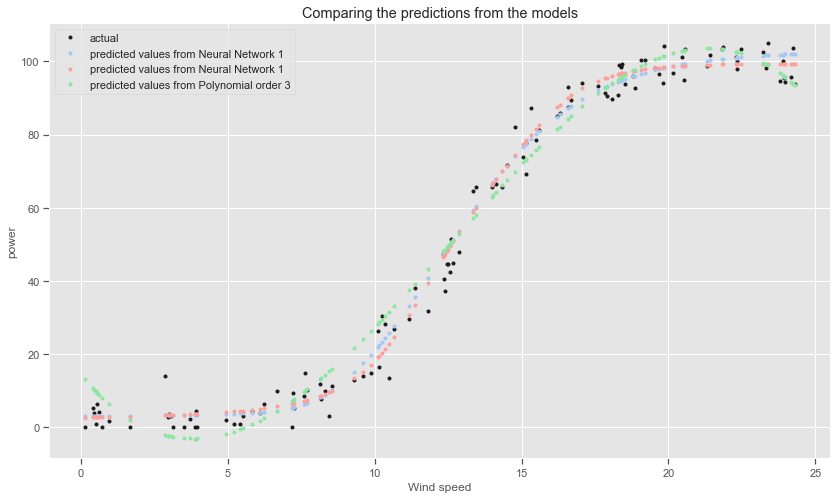

In [265]:
plt.plot(X_test, y_test, '.k', label ='actual')
plt.plot(X_test, model_predictions,'b.', label="predicted values from Neural Network 1")
plt.plot(X_test, model2_predictions,'r.', label="predicted values from Neural Network 1")
plt.plot(X_test, poly3_predictions, 'g.', label="predicted values from Polynomial order 3")
plt.xlabel("Wind speed")
plt.ylabel("power")
plt.title("Comparing the predictions from the models")
plt.legend()
plt.show()

### Look at evaluation metrics for the two models:
Root mean squared error below.
I will leave out one of the neural networks.

#### Polynomial 3

In [257]:
print('Mean squared error: %.2f' % mean_squared_error(y_test,poly3_predictions ))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, poly3_predictions))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test,poly3_predictions )))

Mean squared error: 33.32
Coefficient of determination: 0.98
Root Mean Squared Error: 5.77


In [258]:
train_mse2 = model2.evaluate(X_train, y_train, verbose=0)
test_mse2 = model2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse2, test_mse2))

Train: 16.145, Test: 16.666


In [259]:
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, np.sqrt(error)))

MSE: 17.986, RMSE: 4.241


In [260]:
# evaluate the model2
error = model2.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f ' % (error, np.sqrt(error)))

MSE: 16.666, RMSE: 4.082 


In [263]:
accuracy = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 17.9858


In [164]:
import tensorflow.keras as kr
from tensorflow.keras.models import load_model
model = load_model('model.h5')
model2=load_model('model2.h5')

In [170]:
import pickle
import joblib
# In the specific case of scikit-learn, it may be better to use joblib’s replacement of pickle
#from joblib import dump, load

#model_poly3 = joblib.load('model_poly3.joblib')
mod_poly3 = joblib.load('model_poly3.pkl')

In [179]:
win12 = np.array([[12, 12**2, 12**3]])
#win12 =np.array(win12)
mod_poly3.predict(win12)

array([[45.01454843]])

In [180]:
model2.predict([12])

array([[42.060673]], dtype=float32)

In [181]:
model2.predict([24.4])

array([[99.418755]], dtype=float32)

In [183]:
model2.predict([24.4])[0][0]

99.418755

In [176]:
model.predict([24.4])[0][0]

102.05726

In [185]:
model.predict([12])

array([[43.186234]], dtype=float32)


### Summary and Conclusions

Overall there are limitations in what we can predict given this dataset. As shown above in the research section, usually more features are used in predicting power output from wind speeds. Mention some of these here.
It is still impressive how an artificial neural network can quite closely model the power curve given such limited inputs as a single column of numbers.
Playing with the neural networks does seem to involve a lot of trial and error but I think I would need to learn more about why you would choose one parameter over another, the number of neurons, number of layers, cost functions etc.
The model seems to under predict the power values for the lower values of speed. This is as I expected earlier given that when wind speeds are too low to generate power, the stored power is used later. Look back at the article that mentioned this above.

The dataset was cleaned by removing some of the zero values as initially leaving all the zero values in seemed to pull the curve down too much and the predictions were quite a bit off. 


model.add(kr.layers.BatchNormalization())

error = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, np.sqrt(error)))

The first time I looked at this I was wondering if the data values represented measurements over a particular period of time and if the lower values of power might be related to the time taken for the turbines to get up and running before they could generate any power or if some of the zero power values were related to periodic maintenance when the turbines might get switched off. There does seem to be some linear relationship between the two variables for the middle portion of the dataset and the power generated does seem to level off after a particular point but overall the relationship is strong but non-linear.

However looking at the raw data in the csv file, the rows are ordered by ascending values of speed column with the corresponding power values in the other column. There is no indication as to how the data values were collected and therefore I don't think I can make any judgements about the data over a particular timeframe. There are only two columns of numerical data provided with no indication provided as to their measurement units.  I will just focus on trying to use some algorithms to predict the power values based on the input values of speed. 

https://www.computing.dcu.ie/~humphrys/Notes/Neural/sigmoid.html
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

## References

- [power production dataset](https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv) from Ian McLoughlin Github

### Some resources on wind energy
- [The Irish Wind Energy Association (IWEA)](https://www.iwea.com/about-us/about-us)
- [ESBN Connected Wind Farms](https://www.esbnetworks.ie/new-connections/generator-connections/generator-connection-statistics). 
- http://www.eirgridgroup.com/how-the-grid-works/renewables/
- [WindEurope](https://windeurope.org/data-and-analysis/)
- [how to calculate power output of wind](https://www.windpowerengineering.com/calculate-wind-power-output/)
- [calculating energy production from weather forecast in Python](https://medium.com/planet-os/calculating-energy-production-from-weather-forecast-in-python-3c990047daa)
- [Wind Turbine Power Curve Modeling Using
Advanced Parametric and Nonparametric Methods](http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf)
- https://www.researchgate.net/publication/257748412_Using_machine_learning_to_predict_wind_turbine_power_output

- Using machine learning to predict wind turbine power output by A Clifton, L Kilcher, J K Lundquist and P Fleming, ENVIRONMENTAL RESEARCH LETTERS, doi:10.1088/1748-9326/8/2/024009, Environ. Res. Lett. 8 (2013) 024009 (8pp)

- Wind Turbine Power Curve Modeling Using Advanced Parametric and Nonparametric Methods by Shahab Shokrzadeh, Student Member, IEEE, Mohammad Jafari Jozani, and Eric Bibeau. IEEE TRANSACTIONS ON SUSTAINABLE ENERGY, VOL. 5, NO. 4, OCTOBER 2014.  Available from https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6894235


### 

- Website: [Machine Learning Mastery](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/)[12345]

- Website: [Polynomial Regression with Scikit learn: What You Should Know](https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2)

- Website: [Machine Learning: Polynomial Regression with Python](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)


- Website: [Linear Regression Example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py)

- Website: [Polynomial Regression with Python](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)
- Website: [Python | Implementation of Polynomial Regression](https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/)

- Website: [Polynomial Regression in Python](https://medium.com/ai-in-plain-english/implementing-polynomial-regression-in-python-d9aedf520d56)

- Video: [Understanding Polynomial Regression](https://www.youtube.com/watch?v=UedwCvFGlvU) by 
Mazen Ahmed

- Website: [What does RMSE really mean?](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e) Blog article by James Moody

- Website: [Batch Normalization Tensorflow Keras Example](https://towardsdatascience.com/backpropagation-and-batch-normalization-in-feedforward-neural-networks-explained-901fd6e5393e)

- Website: [How to normalize features in TensorFlow](https://towardsdatascience.com/how-to-normalize-features-in-tensorflow-5b7b0e3a4177)
- Website: [Data Leakage in Machine Learning](https://machinelearningmastery.com/data-leakage-machine-learning/)
- Website: [How to use Data Scaling Improve Deep Learning Model Stability and Performance](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)
- Website: [TensorFlow 2 Tutorial: Get Started in Deep Learning With tf.keras](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)

- Website: [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
- Website: [Install TensorFlow with pip](https://www.tensorflow.org/install/pip)

- Website: [Keras Training Guide](https://keras.io/guides/training_with_built_in_methods/)

- Website: [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

- Website: [pandas.Dataframe.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
 https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/)

### End